In [30]:
from ngsolve import *
from netgen.geom2d import SplineGeometry

from netgen.occ import *
import netgen.meshing as ngm
import numpy as np
from ngsolve.webgui import *
from netgen.geom2d import unit_square

def innerL2(gfu,mesh):
    return Integrate(InnerProduct(gfu,gfu),mesh)
def L2error(gfu,exact,mesh):
    return sqrt(innerL2(gfu-exact,mesh))

draw = False


In [31]:
A= -0.34012
a = 0.34898 
u_exact = IfPos(sqrt(x**2 + y**2)-a, A*log(sqrt(x**2+y**2)),sqrt(0.25-((x)**2+(y)**2)))

# generate a triangular mesh of mesh-size 0.2
geo = SplineGeometry()
geo.AddCircle(c=(0,0), r=1, bc="outer")
n = 4
mesh = Mesh(geo.GenerateMesh(maxh=0.5**n))
phi = IfPos(0.5-sqrt(x**2+y**2), sqrt(0.25-((x)**2+(y)**2)), 0)

#phi = CF(sqrt(0.25-(x-0.5)**2-(y-0.5)**2) if (x-0.5)**2+(y-0.5)**2 < 0.25 else 0)
alpha = Parameter(2) # step size 
# psi initial guess
psik = GridFunction
# proximal galerkin iterations
fesu = H1(mesh, order=12, dirichlet="outer")
fesphi = L2(mesh, order=10) # L_inf 
fes = fesu*fesphi
print("Number of dofs: ", fes.ndof)
 #bilinear form (not linear)
u, delta = fes.TrialFunction()
v, vphi = fes.TestFunction()

# initial guesses
gfu_u = GridFunction(fesu)
gfu_u.Set(1)

psih = GridFunction(fesphi)
psih.Set(1)

uk = GridFunction(fesu)
psik = GridFunction(fesphi)
eps = 1e-6


max_iter_newton = 10
max_iter_PG = 12


wh = GridFunction(fesu)

error_app1 = []
error_app2 = []
for k in range(1,max_iter_PG):
    alpha.Set(2**k)
    print("Iteration of proximal galerkin: ", k)
    # assing uk, psik
    uk.vec.data = gfu_u.vec
    psik.vec.data = psih.vec
    print("Starting newton iteration")
    for i in range(max_iter_newton):
        with TaskManager():
            wh.vec.data = gfu_u.vec
            # bilinear form
            a = BilinearForm(fes)
            a += alpha * grad(u) * grad(v) * dx + delta * v * dx
            a += u*vphi*dx - (delta * exp(psih) * vphi * dx + eps * (grad(delta) * grad(vphi) * dx))
            # linear form rhs
            l = LinearForm(fes)
            # f = 0
            l += (alpha * 0 + psik - psih)*v*dx
            l += (phi + exp(psih))*vphi*dx
            a.Assemble()
            l.Assemble()
            # solve the system
            gfu = GridFunction(fes)
            gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * l.vec
            gfu_u.vec.data = gfu.components[0].vec
            psih.vec.data = psih.vec + gfu.components[1].vec
    print("Exited newton iteration")
    if draw:
        Draw(exp(psih)+phi,mesh)
        Draw(gfu_u,mesh)
        Draw(u_exact,mesh)
    error_app1.append(L2error(gfu_u,u_exact,mesh))
    error_app2.append(L2error(exp(psih)+phi,u_exact,mesh))






    



Number of dofs:  266113
Iteration of proximal galerkin:  1
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  2
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  3
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  4
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  5
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  6
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  7
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  8
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  9
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  10
Starting newton iteration
Exited newton iteration
Iteration of proximal galerkin:  11
Starting newton iteration
Exited newton iteration


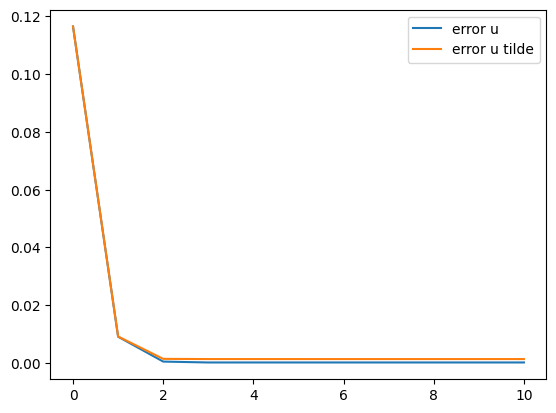

In [32]:
import matplotlib.pyplot as plt
plt.plot(error_app1, label="error u")
plt.plot(error_app2, label="error u tilde")
plt.legend()
plt.show()
